## 2.6. 概率
简单地说，机器学习就是做出预测。

根据病人的临床病史，我们可能想预测他们在下一年心脏病发作的概率。 在飞机喷气发动机的异常检测中，我们想要评估一组发动机读数为正常运行情况的概率有多大。 在强化学习中，我们希望智能体（agent）能在一个环境中智能地行动。 这意味着我们需要考虑在每种可行的行为下获得高奖励的概率。 当我们建立推荐系统时，我们也需要考虑概率。 例如，假设我们为一家大型在线书店工作，我们可能希望估计某些用户购买特定图书的概率。 为此，我们需要使用概率学。 有完整的课程、专业、论文、职业、甚至院系，都致力于概率学的工作。 所以很自然地，我们在这部分的目标不是教授整个科目。 相反，我们希望教给读者基础的概率知识，使读者能够开始构建第一个深度学习模型， 以便读者可以开始自己探索它。

现在让我们更认真地考虑第一个例子：根据照片区分猫和狗。 这听起来可能很简单，但对于机器却可能是一个艰巨的挑战。 首先，问题的难度可能取决于图像的分辨率。
![image_Snipaste_2023-12-09_15-55-27.png](./assets/Snipaste_2023-12-09_15-55-27.png)
![image_Snipaste_2023-12-09_15-55-46.png](./assets/Snipaste_2023-12-09_15-55-46.png)

### 2.6.1. 基本概率论
![image_Snipaste_2023-12-09_15-56-14.png](./assets/Snipaste_2023-12-09_15-56-14.png)



In [1]:
%matplotlib inline
import torch
from torch.distributions import multinomial
from d2l import torch as d2l

在统计学中，我们把从概率分布中抽取样本的过程称为抽样（sampling）。 笼统来说，可以把分布（distribution）看作对事件的概率分配， 稍后我们将给出的更正式定义。 将概率分配给一些离散选择的分布称为多项分布（multinomial distribution）。

为了抽取一个样本，即掷骰子，我们只需传入一个概率向量。 输出是另一个相同长度的向量：它在索引i处的值是采样结果中i出现的次数。

In [2]:
fair_probs = torch.ones([6]) / 6
print(fair_probs)
multinomial.Multinomial(1, fair_probs).sample()

tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])


tensor([0., 0., 0., 0., 0., 1.])

在估计一个骰子的公平性时，我们希望从同一分布中生成多个样本。 如果用Python的for循环来完成这个任务，速度会慢得惊人。 因此我们使用深度学习框架的函数同时抽取多个样本，得到我们想要的任意形状的独立样本数组。

In [6]:
multinomial.Multinomial(10, fair_probs).sample()

tensor([1., 0., 1., 1., 3., 4.])

现在我们知道如何对骰子进行采样，我们可以模拟1000次投掷。 然后，我们可以统计1000次投掷后，每个数字被投中了多少次。 具体来说，我们计算相对频率，以作为真实概率的估计。


In [7]:
# 将结果存储为32位浮点数以进行除法
counts = multinomial.Multinomial(1000, fair_probs).sample()
print(counts)
print(counts / 1000)  # 相对频率作为估计值

tensor([153., 173., 169., 166., 170., 169.])
tensor([0.1530, 0.1730, 0.1690, 0.1660, 0.1700, 0.1690])


因为我们是从一盒公平的骰子中生成的数据，我们知道每个结果都有真是的概率为1/6，大约0.167，所以上面输出的估计值看起来还不错。
我们也可以看到这些概率如何随着时间的退役收敛到真实概率，让我们进行500组实验，每组抽取10个样本。

torch.Size([500, 6])


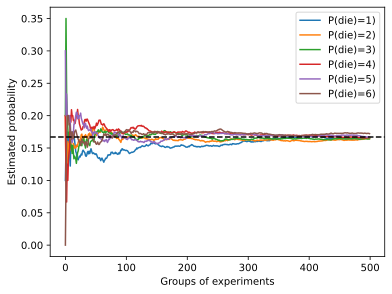

In [8]:
counts = multinomial.Multinomial(10, fair_probs).sample((500,))
print(counts.shape)
cum_counts = counts.cumsum(dim=0)
estimates = cum_counts / cum_counts.sum(dim=1, keepdims=True)
d2l.set_figsize((6, 4.5))
for i in range(6):
    d2l.plt.plot(estimates[:, i].numpy(), label=("P(die)=" + str(i + 1) + ")"))
d2l.plt.axhline(y=0.167, color="black", linestyle="dashed")
d2l.plt.gca().set_xlabel('Groups of experiments')
d2l.plt.gca().set_ylabel('Estimated probability')
d2l.plt.legend();

每条实线对应于骰子的6个值中的一个，并给出骰子在每组实验后出现值的估计概率。 当我们通过更多的实验获得更多的数据时，这6条实体曲线向真实概率收敛。
### 2.6.1.1. 概率论公理
![image_Snipaste_2023-12-09_16-28-06.png](./assets/Snipaste_2023-12-09_16-28-06.png)
### 2.6.1.2. 随机变量

![image_Snipaste_2023-12-09_16-28-34.png](./assets/Snipaste_2023-12-09_16-28-34.png)

### 2.6.2. 处理多个随机变量
很多时候，我们会考虑多个随机变量。 比如，我们可能需要对疾病和症状之间的关系进行建模。 给定一个疾病和一个症状，比如“流感”和“咳嗽”，以某个概率存在或不存在于某个患者身上。 我们需要估计这些概率以及概率之间的关系，以便我们可以运用我们的推断来实现更好的医疗服务。

再举一个更复杂的例子：图像包含数百万像素，因此有数百万个随机变量。 在许多情况下，图像会附带一个标签（label），标识图像中的对象。 我们也可以将标签视为一个随机变量。 我们甚至可以将所有元数据视为随机变量，例如位置、时间、光圈、焦距、ISO、对焦距离和相机类型。 所有这些都是联合发生的随机变量。 当我们处理多个随机变量时，会有若干个变量是我们感兴趣的。

### 2.6.2.1. 联合概率
![image_Snipaste_2023-12-09_16-29-17.png](./assets/Snipaste_2023-12-09_16-29-17.png)

### 2.6.2.2. 条件概率
![image_Snipaste_2023-12-09_16-29-46.png](./assets/Snipaste_2023-12-09_16-29-46.png)

### 2.6.2.3. 贝叶斯定理
![image_Snipaste_2023-12-09_16-30-22.png](./assets/Snipaste_2023-12-09_16-30-22.png)

### 2.6.2.4. 边际化

![image_Snipaste_2023-12-09_16-30-50.png](./assets/Snipaste_2023-12-09_16-30-50.png)

### 2.6.2.5. 独立性

![image_Snipaste_2023-12-09_16-31-14.png](./assets/Snipaste_2023-12-09_16-31-14.png)

### 2.6.2.6. 应用

![image_Snipaste_2023-12-09_16-31-41.png](./assets/Snipaste_2023-12-09_16-31-41.png)

![image_Snipaste_2023-12-09_16-32-00.png](./assets/Snipaste_2023-12-09_16-32-00.png)

![image_Snipaste_2023-12-09_16-32-25.png](./assets/Snipaste_2023-12-09_16-32-25.png)

![image_Snipaste_2023-12-09_16-32-40.png](./assets/Snipaste_2023-12-09_16-32-40.png)

### 2.6.3. 期望和方差

![image_Snipaste_2023-12-09_16-33-04.png](./assets/Snipaste_2023-12-09_16-33-04.png)

### 2.6.4. 小结

1. 我们可以从概率分布中采样。
2. 我们可以使用联合分布、条件分布、Bayes定理、边缘化和独立性假设来分析多个随机变量。
3. 期望和方差为概率分布的关键特征的概括提供了实用的度量形式。